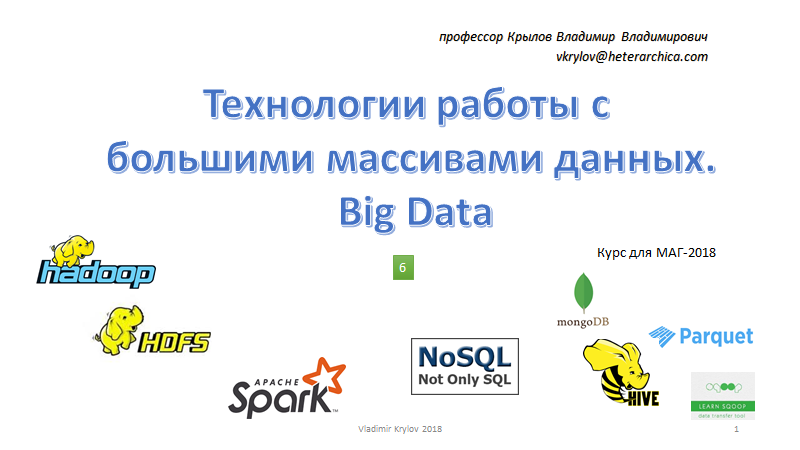

# Применение Data Frames в PySpark

In [1]:
!pip install pyspark

In [2]:
import pyspark
import random

In [3]:
!pip install sparkmonitor

In [4]:
import sparkmonitor

In [5]:
'''
!jupyter nbextension install sparkmonitor --py --user --symlink 
!jupyter nbextension enable sparkmonitor --py --user            
!jupyter serverextension enable --py --user sparkmonitor
!ipython profile create && echo "c.InteractiveShellApp.extensions.append('sparkmonitor.kernelextension')" >>  $(ipython profile locate default)/ipython_kernel_config.py
'''

'\n!jupyter nbextension install sparkmonitor --py --user --symlink \n!jupyter nbextension enable sparkmonitor --py --user            \n!jupyter serverextension enable --py --user sparkmonitor\n!ipython profile create && echo "c.InteractiveShellApp.extensions.append(\'sparkmonitor.kernelextension\')" >>  $(ipython profile locate default)/ipython_kernel_config.py\n'

In [51]:
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
import time
import pandas as pd
from pyspark.sql import SparkSession
import pandas as pd

conf = SparkConf()
conf.setAppName('My spark')
conf.setMaster('local[*]')

sc=SparkContext.getOrCreate(conf=conf)
spark= SparkSession.builder.getOrCreate()

print(conf.toDebugString())

spark.app.name=My spark
spark.master=local[*]
spark.submit.deployMode=client
spark.ui.showConsoleProgress=true


### Сконструируем dataframe из данных Titanic

In [7]:
data1 = {'PassengerId': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5},
         'Name': {0: 'Owen', 1: 'Florence', 2: 'Laina', 3: 'Lily', 4: 'William'},
         'Sex': {0: 'male', 1: 'female', 2: 'female', 3: 'female', 4: 'male'},
         'Survived': {0: 0, 1: 1, 2: 1, 3: 1, 4: 0}}

data2 = {'PassengerId': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5},
         'Age': {0: 22, 1: 38, 2: 26, 3: 35, 4: 35},
         'Fare': {0: 7.3, 1: 71.3, 2: 7.9, 3: 53.1, 4: 8.0},
         'Pclass': {0: 3, 1: 1, 2: 3, 3: 1, 4: 3}}

df1_pd = pd.DataFrame(data1, columns=data1.keys())
df2_pd = pd.DataFrame(data2, columns=data2.keys())

Посмотрим как выглядят датафреймы

In [8]:
df1_pd

,PassengerId,Name,Sex,Survived
0,1,Owen,male,0
1,2,Florence,female,1
2,3,Laina,female,1
3,4,Lily,female,1
4,5,William,male,0


In [9]:
df2_pd

,PassengerId,Age,Fare,Pclass
0,1,22,7.3,3
1,2,38,71.3,1
2,3,26,7.9,3
3,4,35,53.1,1
4,5,35,8.0,3


Для того, чтобы  pandas dataframe преобразовались в  Spark dataframe и их хранение могло осуществляться на кластере в виде RDD нужно выполнить код такого типа

In [10]:
df1 = spark.createDataFrame(df1_pd)
df2 = spark.createDataFrame(df2_pd)


Теперь, чтобы видеть датафрейм, нужно использовать метод

In [11]:
df1.show()

+-----------+--------+------+--------+
|PassengerId|    Name|   Sex|Survived|
+-----------+--------+------+--------+
|          1|    Owen|  male|       0|
|          2|Florence|female|       1|
|          3|   Laina|female|       1|
|          4|    Lily|female|       1|
|          5| William|  male|       0|
+-----------+--------+------+--------+



Схему хранения датафрейма можно видеть

In [12]:
df1.printSchema()

root
 |-- PassengerId: long (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Survived: long (nullable = true)



### Для осуществления действий над датафреймами Spark применяются следующие  5 basic verbs for Spark

#### Select

Принимает либо список имен столбцов, либо распакованный список.

In [13]:
cols1 = ['PassengerId', 'Name']
df1.select(cols1).show()

+-----------+--------+
|PassengerId|    Name|
+-----------+--------+
|          1|    Owen|
|          2|Florence|
|          3|   Laina|
|          4|    Lily|
|          5| William|
+-----------+--------+



#### Filter

Filter принимает функциональное выражение для столбца или выражение на SQL ---

Filter с функциональным выражением для столбца

In [14]:
df1.filter(df1.Sex == 'female').show()

+-----------+--------+------+--------+
|PassengerId|    Name|   Sex|Survived|
+-----------+--------+------+--------+
|          2|Florence|female|       1|
|          3|   Laina|female|       1|
|          4|    Lily|female|       1|
+-----------+--------+------+--------+



Фильтр с выражением на SQL

In [15]:
df1.filter("Sex='female'").show()

+-----------+--------+------+--------+
|PassengerId|    Name|   Sex|Survived|
+-----------+--------+------+--------+
|          2|Florence|female|       1|
|          3|   Laina|female|       1|
|          4|    Lily|female|       1|
+-----------+--------+------+--------+



#### Изменение (Mutate) или создание новых столбцов

Создание новых столбцов в Spark использует метод .withColumn(). 

In [16]:
df2.withColumn('AgeTimesFare', df2.Age*df2.Fare).show()

+-----------+---+----+------+------------+
|PassengerId|Age|Fare|Pclass|AgeTimesFare|
+-----------+---+----+------+------------+
|          1| 22| 7.3|     3|       160.6|
|          2| 38|71.3|     1|      2709.4|
|          3| 26| 7.9|     3|       205.4|
|          4| 35|53.1|     1|      1858.5|
|          5| 35| 8.0|     3|       280.0|
+-----------+---+----+------+------------+



#### Суммаризация и агрегирование (Summarize and group by) датафрейма

Сначала нужно конвертировать датафрейм в объект GroupedData с помощью метода groupby() ,
а затем вызвать функции агрегирования

In [17]:
gdf2 = df2.groupby('Pclass')
gdf2

#### Агрегирование. Это может быть вычисление среднего по столбцу

In [18]:
avg_cols = ['Age', 'Fare']
gdf2.avg(*avg_cols).show()

+------+------------------+-----------------+
|Pclass|          avg(Age)|        avg(Fare)|
+------+------------------+-----------------+
|     1|              36.5|             62.2|
|     3|27.666666666666668|7.733333333333333|
+------+------------------+-----------------+



Чтобы выполнить разные агрегирующие функции за один раз, следует передать их dictionary.

In [19]:
gdf2.agg({'*': 'count', 'Age': 'avg', 'Fare':'sum'}).show()

+------+--------+------------------+---------+
|Pclass|count(1)|          avg(Age)|sum(Fare)|
+------+--------+------------------+---------+
|     1|       2|              36.5|    124.4|
|     3|       3|27.666666666666668|     23.2|
+------+--------+------------------+---------+



#### Имена столбцов можно изменить с помощью метода toDF().

In [20]:
(
    gdf2
    .agg({'*': 'count', 'Age': 'avg', 'Fare':'sum'})
    .toDF('Pclass', 'counts', 'average_age', 'total_fare')
    .show()
)

+------+------+------------------+----------+
|Pclass|counts|       average_age|total_fare|
+------+------+------------------+----------+
|     1|     2|              36.5|     124.4|
|     3|     3|27.666666666666668|      23.2|
+------+------+------------------+----------+



#### Сортировка столбца - Arrange (sort)

In [21]:
df2.sort('Fare', ascending=False).show()

+-----------+---+----+------+
|PassengerId|Age|Fare|Pclass|
+-----------+---+----+------+
|          2| 38|71.3|     1|
|          4| 35|53.1|     1|
|          5| 35| 8.0|     3|
|          3| 26| 7.9|     3|
|          1| 22| 7.3|     3|
+-----------+---+----+------+



#### Объединения (Joins and unions)

Существует два способа комбинирования данных - Joins и unions. Идея здесь такая же, как  joining and unioning tables in SQL.

Joins

Например так можно join два  titanic dataframes по столбцу PassengerId

In [22]:
df1.join(df2, ['PassengerId']).show()

+-----------+--------+------+--------+---+----+------+
|PassengerId|    Name|   Sex|Survived|Age|Fare|Pclass|
+-----------+--------+------+--------+---+----+------+
|          5| William|  male|       0| 35| 8.0|     3|
|          1|    Owen|  male|       0| 22| 7.3|     3|
|          3|   Laina|female|       1| 26| 7.9|     3|
|          2|Florence|female|       1| 38|71.3|     1|
|          4|    Lily|female|       1| 35|53.1|     1|
+-----------+--------+------+--------+---+----+------+



Можно также делать  join by conditions, но при этом создаются дубликаты столбцов, если ключи имеют одинаковое имя. Избежать этого можно передавая список ключей  объединения. Если необходимо осуществить нечеткое - nonequi joins, то нужно переименовать ключи до  join.

#### Nonequi joins

работать может весьма медленно. Однако в отличии от Hive  это возможно в Spark

In [23]:
df1.join(df2, df1.PassengerId <= df2.PassengerId).show() # Note the duplicate col names

+-----------+--------+------+--------+-----------+---+----+------+
|PassengerId|    Name|   Sex|Survived|PassengerId|Age|Fare|Pclass|
+-----------+--------+------+--------+-----------+---+----+------+
|          1|    Owen|  male|       0|          1| 22| 7.3|     3|
|          1|    Owen|  male|       0|          2| 38|71.3|     1|
|          1|    Owen|  male|       0|          3| 26| 7.9|     3|
|          1|    Owen|  male|       0|          4| 35|53.1|     1|
|          1|    Owen|  male|       0|          5| 35| 8.0|     3|
|          2|Florence|female|       1|          2| 38|71.3|     1|
|          2|Florence|female|       1|          3| 26| 7.9|     3|
|          2|Florence|female|       1|          4| 35|53.1|     1|
|          2|Florence|female|       1|          5| 35| 8.0|     3|
|          3|   Laina|female|       1|          3| 26| 7.9|     3|
|          3|   Laina|female|       1|          4| 35|53.1|     1|
|          3|   Laina|female|       1|          5| 35| 8.0|   

#### Unions
Union() возвращает dataframe из одного union или двух dataframes

In [24]:
df1.union(df1).show()

+-----------+--------+------+--------+
|PassengerId|    Name|   Sex|Survived|
+-----------+--------+------+--------+
|          1|    Owen|  male|       0|
|          2|Florence|female|       1|
|          3|   Laina|female|       1|
|          4|    Lily|female|       1|
|          5| William|  male|       0|
|          1|    Owen|  male|       0|
|          2|Florence|female|       1|
|          3|   Laina|female|       1|
|          4|    Lily|female|       1|
|          5| William|  male|       0|
+-----------+--------+------+--------+



Некоторые из итерационных алгоритмов создают связанные объекты union (). Существует потенциальная возможность, что время выполнения может стать слишком долгим, что может вызвать проблемы с производительностью или ошибки.

Одним из распространенных симптомов проблем производительности, вызванных цепными объединениями в цикле for, это именно требование большего чем ожидалось времени  для повторения цикла. В этом случае repartition () и checkpoint () могут помочь решить эту проблему.

### Dataframe input and output (I/O)


Существует два класса pyspark.sql.DataFrameReader и pyspark.sql.DataFrameWriter, которые обрабатывают ввод / вывод данных. В зависимости от конфигурации файлы могут быть сохранены локально, с помощью  Hive или с файловой системой Hadoop (HDFS).

Общие методы сохранения файлов данных в файлах включают saveAsTable () для таблиц Hive и saveAsFile () для локальной или файловой системы Hadoop.

#### Spark.sql API

Многие из операций, которые ,skb gjrfpfys, можно получить, написав SQL (Hive) запросы в spark.sql (). Это также удобный способ чтения таблиц Hive в DataFrams Spark. Чтобы создать существующую фреймворк Spark, используемый для spark.sql (), нужно зарегистрировать указанный фрейм данных как временную таблицу.

Temp tables
Как пример, можно определить для двух dataframes две temp tables и потом join их с помощью spark.sql().

In [25]:
df1.createOrReplaceTempView('df1_temp')
df2.createOrReplaceTempView('df2_temp')

In [26]:
query = '''
    select 
        a.PassengerId,
        a.Name,
        a.Sex,
        a.Survived,
        b.Age,
        b.Fare,
        b.Pclass
    from df1_temp a
    join df2_temp b
        on a.PassengerId = b.PassengerId'''
dfj = spark.sql(query)

In [27]:
dfj.show()

+-----------+--------+------+--------+---+----+------+
|PassengerId|    Name|   Sex|Survived|Age|Fare|Pclass|
+-----------+--------+------+--------+---+----+------+
|          5| William|  male|       0| 35| 8.0|     3|
|          1|    Owen|  male|       0| 22| 7.3|     3|
|          3|   Laina|female|       1| 26| 7.9|     3|
|          2|Florence|female|       1| 38|71.3|     1|
|          4|    Lily|female|       1| 35|53.1|     1|
+-----------+--------+------+--------+---+----+------+



Использование возможностей PySpark на более глубоком уровне

В этом разделе говорится о некоторых идеях и полезных инструментах, связанных с этими идеями, которые ямогут помочь при настройке производительности или отладке данных. Первым из них является различие между двумя типами операций: преобразованиями-  transformations и действиями - actions , а также метод explain (), который выводит план выполнения кадра данных.

Explain(), transformations, and actions

Когда создается dataframe в PySpark, в отличие от объектов Python, данные-фреймы являются  lazy evaluated. Это означает, что большинство операций - это преобразования, которые изменяют план выполнения DAG, как Spark должен обрабатывать данные, но план не выполняется до тех пор, пока мы не вызовем и не выполним действия.

Например, если я хочу join df1 и df2 по ключу PassengerId, как и раньше:

In [28]:
df1.explain()

== Physical Plan ==
Scan ExistingRDD[PassengerId#0L,Name#1,Sex#2,Survived#3L]


In [29]:
df2.explain()

== Physical Plan ==
Scan ExistingRDD[PassengerId#8L,Age#9L,Fare#10,Pclass#11L]


In [30]:
dfj1 = df1.join(df2, ['PassengerId'])
dfj1.explain()

== Physical Plan ==
*(5) Project [PassengerId#0L, Name#1, Sex#2, Survived#3L, Age#9L, Fare#10, Pclass#11L]
+- *(5) SortMergeJoin [PassengerId#0L], [PassengerId#8L], Inner
   :- *(2) Sort [PassengerId#0L ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(PassengerId#0L, 200)
   :     +- *(1) Filter isnotnull(PassengerId#0L)
   :        +- Scan ExistingRDD[PassengerId#0L,Name#1,Sex#2,Survived#3L]
   +- *(4) Sort [PassengerId#8L ASC NULLS FIRST], false, 0
      +- Exchange hashpartitioning(PassengerId#8L, 200)
         +- *(3) Filter isnotnull(PassengerId#8L)
            +- Scan ExistingRDD[PassengerId#8L,Age#9L,Fare#10,Pclass#11L]


В этом случае, join() - представляет собой  transformation в котором план для  Spark объединить (join) два dataframes, но он не выполняется если не вызывано действие - аction, такое как .count(), действие над данными, фактически определенными в df1 и df2 для того, чтобы возвратить Python object (integer).

In [31]:

dfj1.count()

5

Что происходит если сделать join через API spark.sql () вместо вызова .join ()? В этом случае как кажется создается тот же план выполнения. Но это не всегда так. Хороший план выполнения равен хорошей производительности, и explain() может дать  много, когда нужно настроить работу Spark.

In [32]:
query = '''
    select 
        a.PassengerId,
        a.Name,
        a.Sex,
        a.Survived,
        b.Age,
        b.Fare,
        b.Pclass
    from df1_temp a
    join df2_temp b
        on a.PassengerId = b.PassengerId'''
dfj = spark.sql(query)
dfj.explain()

== Physical Plan ==
*(5) Project [PassengerId#0L, Name#1, Sex#2, Survived#3L, Age#9L, Fare#10, Pclass#11L]
+- *(5) SortMergeJoin [PassengerId#0L], [PassengerId#8L], Inner
   :- *(2) Sort [PassengerId#0L ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(PassengerId#0L, 200)
   :     +- *(1) Filter isnotnull(PassengerId#0L)
   :        +- Scan ExistingRDD[PassengerId#0L,Name#1,Sex#2,Survived#3L]
   +- *(4) Sort [PassengerId#8L ASC NULLS FIRST], false, 0
      +- Exchange hashpartitioning(PassengerId#8L, 200)
         +- *(3) Filter isnotnull(PassengerId#8L)
            +- Scan ExistingRDD[PassengerId#8L,Age#9L,Fare#10,Pclass#11L]


### Data persistence: cache() and checkpoint()

#### caching
Правильное кэширование caching - это ключ к высокой производительности Spark. 

A rule of thumb is that

Cache a dataframe when it is used multiple times in the script.
Keep in mind that it is only cached after the first action, such as saveAsTable(). If for whatever reason I want to make sure the data is cached before I save the dataframe, then I have to call an action like .count().

Эмпирическое правило состоит в том, что

- Кэшируй датафрейм, когда он используется несколько раз в скрипте.

Имейте в виду, что он только кэшируется после первого действия, такого как saveAsTable (). Если по какой-либо причине хочется убедиться, что данные кэшируются до того, как  сохраним фрейм данных, тогда нужно вызвать действие, подобное .count ().

In [33]:
df1.cache()

DataFrame[PassengerId: bigint, Name: string, Sex: string, Survived: bigint]

Метод .cache() работает как inplace method.

In [34]:
df1 = df1.cache()

Всегда можно проверить уровень хранения для любого датафрейма

In [35]:
df1.storageLevel

StorageLevel(True, True, False, True, 1)

Чтобы un-cache данный dataframe, используется метод unpersist()

In [36]:
df1.unpersist()
df1.storageLevel

StorageLevel(False, False, False, False, 1)

Существует 4 уровня кеширования, которые можно настроить с помощью функции persist (), но я не видел случая, когда  тонкая настройка использовалась.

#### Checkpointing

Иногда цепочки слишком большого числа union () вызывают проблемы с производительностью или даже  ошибки в памяти. checkpoint () усекает план выполнения и сохраняет контрольную точку во временном месте на диске.

Специалисты рекомендуют кэширование перед контрольной точкой, поэтому Spark не должен читать данные с диска после его контрольной точки.

Чтобы использовать checkpoint (), нужно указать временное расположение файла, чтобы сохранить имя файла, обратившись к объекту sparkContext из SparkSession.

In [37]:
sc.setCheckpointDir("checkpointdir") # save to c:/checkpointdir

In [38]:
df = df1.join(df1, ['PassengerId'])
df.join(df1, ['PassengerId']).explain()

== Physical Plan ==
*(8) Project [PassengerId#0L, Name#1, Sex#2, Survived#3L, Name#373, Sex#374, Survived#375L, Name#384, Sex#385, Survived#386L]
+- *(8) SortMergeJoin [PassengerId#0L], [PassengerId#383L], Inner
   :- *(5) Project [PassengerId#0L, Name#1, Sex#2, Survived#3L, Name#373, Sex#374, Survived#375L]
   :  +- *(5) SortMergeJoin [PassengerId#0L], [PassengerId#372L], Inner
   :     :- *(2) Sort [PassengerId#0L ASC NULLS FIRST], false, 0
   :     :  +- Exchange hashpartitioning(PassengerId#0L, 200)
   :     :     +- *(1) Filter isnotnull(PassengerId#0L)
   :     :        +- Scan ExistingRDD[PassengerId#0L,Name#1,Sex#2,Survived#3L]
   :     +- *(4) Sort [PassengerId#372L ASC NULLS FIRST], false, 0
   :        +- ReusedExchange [PassengerId#372L, Name#373, Sex#374, Survived#375L], Exchange hashpartitioning(PassengerId#0L, 200)
   +- *(7) Sort [PassengerId#383L ASC NULLS FIRST], false, 0
      +- ReusedExchange [PassengerId#383L, Name#384, Sex#385, Survived#386L], Exchange hashpartit


Можно также выполнить checkpoint() после первого join чтобы обрезать план выполнения.

In [48]:
type(df1.join(df1, ['PassengerId']))
# df = df1.join(df1, ['PassengerId']).checkpoint()
# df.join(df1, ['PassengerId']).explain()

pyspark.sql.dataframe.DataFrame

Partitions and repartition()
Другой распространенной причиной проблем с производительностью может быть наличие слишком многих разделов - partitions. Чтобы проверить количество разделов, используйте .rdd.getNumPartitions ()

In [49]:
df1.rdd.getNumPartitions()

8

Этот блок данных, несмотря на наличие только 5 строк, имеет 12 разделов. Это слишком много. Мы можем переделать хранение так, чтобы использовался  только  1 раздел.

In [50]:
df1_repartitioned = df1.repartition(1)
df1_repartitioned.rdd.getNumPartitions()

1

# End of slides

Next lecture bases on https://medium.com/civis-analytics/prediction-at-scale-with-scikit-learn-and-pyspark-pandas-udfs-51d5ebfb2cd8 and notebook https://github.com/changhsinlee/changhsinlee.github.io/blob/master/notebook/2018-03-04-pyspark-dataframe-basics/dataframe-basics.ipynb¶